In [2]:
#my modules
import sys
import os

# Add the parent directory to the path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from bass_lv_v2 import SVBassLV
from heston import Heston, implied_vol
from utils import Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R
from plot import plot_bass_result
import scipy.interpolate as interp

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add volatility path if needed
volatility_path = "/Users/alexandr/Desktop/bass_lv"
if volatility_path not in sys.path:
    sys.path.append(volatility_path)

import volatility as vol

### The market model is SVI calibrated to the market smiles 

In [17]:
data = vol.YFinanceData.load_from_disk("spx-2024-02-20.xlsx")
min_abs_delta = 0.01

print(f"Date: {data.access_time.tz_convert('America/New_York').date()}") 
print("Available maturities:", ", ".join(m.strftime("%Y-%m-%d") for m in data.get_maturities()))

maturities = ["2024-02-23", "2024-03-01", "2024-03-08", "2024-03-15", "2024-03-22"] + [m.strftime("%Y-%m-%d") for m in data.get_maturities()[28:]]
print("Maturities we'll use:", ", ".join(maturities))

Date: 2024-02-20
Available maturities: 2024-02-20, 2024-02-21, 2024-02-22, 2024-02-23, 2024-02-26, 2024-02-27, 2024-02-28, 2024-02-29, 2024-03-01, 2024-03-04, 2024-03-05, 2024-03-06, 2024-03-07, 2024-03-08, 2024-03-11, 2024-03-12, 2024-03-13, 2024-03-14, 2024-03-15, 2024-03-18, 2024-03-19, 2024-03-20, 2024-03-21, 2024-03-22, 2024-03-25, 2024-03-26, 2024-03-27, 2024-03-28, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19
Maturities we'll use: 2024-02-23, 2024-03-01, 2024-03-08, 2024-03-15, 2024-03-22, 2024-04-05, 2024-04-19, 2024-04-30, 2024-05-17, 2024-05-31, 2024-06-21, 2024-06-28, 2024-07-19, 2024-07-31, 2024-08-16, 2024-09-20, 2024-09-30, 2024-10-18, 2024-11-15, 2024-12-20, 2024-12-31, 2025-01-17, 2025-02-21, 2025-03-21, 2025-06-20, 2025-12-19


In [18]:
T = []
F = []
X = []
K = []
W = []
IV = []
for m in maturities:
    T.append(data.forward_prices.loc[m].timeToMaturity)
    F.append(data.forward_prices.loc[m].forwardPrice)
    x, w = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=True, as_numpy=True)
    k, iv = data.get_implied_vol(m, min_abs_delta=min_abs_delta, return_total_var=False, as_numpy=True)
    X.append(x)
    W.append(w)
    K.append(k)
    IV.append(iv)

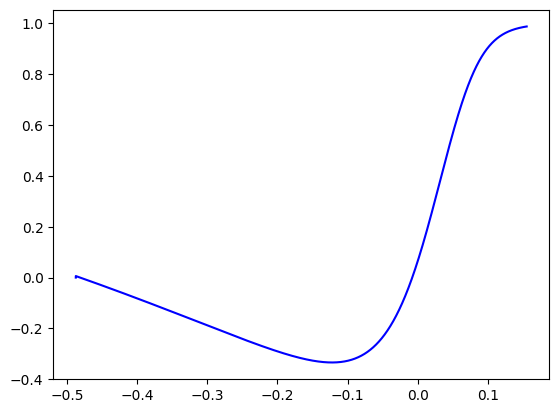

In [76]:
i = 10

x = X[i]  # Forward log moneyness
w = W[i]  # Total implied variance
svi = vol.SVI.calibrate(x, w)

# Create a grid of forward log moneyness values
grid = np.linspace(np.min(x), np.max(x), 10_000)

itv = svi(grid)

iv = np.sqrt(itv / T[i]) 
strikes = np.exp(grid) * F[0]
dx = strikes[1] - strikes[0]

cdf_values = np.diff(bs_call_price(F[0], iv, T[i], strikes), n=1) / dx + 1

cdf_interp = interp.interp1d(strikes[1:], cdf_values, kind='linear', bounds_error=False, fill_value=(0, 1))
qf_interp = interp.interp1d(cdf_values, strikes[1:], kind='linear', bounds_error=False, fill_value=(strikes[1], strikes[-1]))

marginal = Density(cdf_interp, qf_interp)

plt.plot(grid, marginal.cdf(strikes), color='blue')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


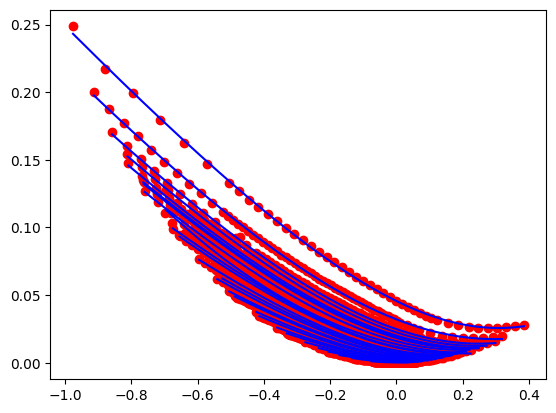

In [62]:
# Cell 5 - Complete the loop with proper formulas
svi_dict = {}

for i in range(len(T)):
    
    x = X[i]  # Forward log moneyness
    w = W[i]  # Total implied variance
    svi = vol.SVI.calibrate(x, w)
    
    # Create a grid of forward log moneyness values
    grid = np.linspace(np.min(x), np.max(x), 10_000)
    
    # Get total implied variance from SVI function
    itv = svi(grid)
    
    plt.plot(grid, itv, color='blue')
    plt.scatter(x, w, color='red')

    # Store the marginal for later use (you might want to add this)
    svi_dict[T[i]] = svi